# additional features

We're going to use the pointcloud file where Hendrik has calculated some geometric features. We'll input this into a model using samples, which we will then pass to Hendrik to utilise on the full sample

In [1]:
import laspy
import numpy as np
import matplotlib.pyplot as plt     
import seaborn as sns
import open3d as o3d
import pandas as pd
from dotenv import load_dotenv
import json
from upath import UPath
import os
# Load environment variables from .env file if it exists
load_dotenv()
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
#from src import data_loader

sns.set_theme(style="whitegrid")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import psutil
import os

# Get current process (Jupyter kernel)
process = psutil.Process(os.getpid())
mem_info = process.memory_info()

print(f"Current notebook memory usage:")
print(f"  RSS (resident set): {mem_info.rss / 1e9:.2f} GB")
print(f"  VMS (virtual):      {mem_info.vms / 1e9:.2f} GB")

# Get total system memory
total_mem = psutil.virtual_memory().total / 1e9
used_mem = psutil.virtual_memory().used / 1e9
available = psutil.virtual_memory().available / 1e9

print(f"\nSystem memory:")
print(f"  Total:     {total_mem:.2f} GB")
print(f"  Used:      {used_mem:.2f} GB")
print(f"  Available: {available:.2f} GB")
print(f"  % used:    {psutil.virtual_memory().percent:.1f}%")

Current notebook memory usage:
  RSS (resident set): 0.44 GB
  VMS (virtual):      12.52 GB

System memory:
  Total:     270.13 GB
  Used:      8.03 GB
  Available: 260.20 GB
  % used:    3.7%


In [3]:
DATA_PATH = Path("/media/HDD_disk/james/lidar_REALLOCATE")
DATA_LAZ_PATH = DATA_PATH / "bologna_precalculated_subsampled.laz"

In [4]:
#data_loader.fetch_and_process_lidar("bologna_precalculated_subsampled.laz")

### Let's remind outselves of the classifications
- 0 not yet classified (nothing done yet)
- 1 unclassified (actively marked as nothing)
- 2 ground, sidewalk
- 3,4,5 vegetation, low(gras) medium(shrubbery) high (trees)
- 6 buildings
- 8 street furniture
- 10 street markings
- 11 street, pavement
- 12 bike lanes
- 13 temporary things(bicycles, trashcans)
- 15 cars, trucks

In [5]:
import sys

def las_in_memory_size(las):
    """
    Estimate the in-memory size (in bytes) of a laspy LAS object.
    """
    total_size = 0
    for dim in list(las.point_format.dimension_names):
        arr = getattr(las, dim)
        total_size += arr.nbytes if hasattr(arr, 'nbytes') else sys.getsizeof(arr)
    return total_size

# Example usage:
# las = laspy.read("your_file.las")
# print(f"In-memory size: {las_in_memory_size(las)/1e6:.2f} MB")

def describe_las(las):
    print(f"In-memory size: {las_in_memory_size(las)/1e6:.2f} MB")
    print(f"Point Format: {las.header.point_format}")
    print(f"Number of Points: {las.header.point_count}")
    print("Available Dimensions:", list(las.point_format.dimension_names))
    print("Bounding Box:")
    print(f"  X: {las.header.mins[0]} to {las.header.maxs[0]}")
    print(f"  Y: {las.header.mins[1]} to {las.header.maxs[1]}")
    print(f"  Z: {las.header.mins[2]} to {las.header.maxs[2]}")
    print("Scale:", las.header.scales)
    print("Offset:", las.header.offsets)
    try:
        print("CRS:", las.header.parse_crs())
    except:
        print("CRS: Not defined")

In [6]:

las = laspy.read(DATA_LAZ_PATH)

In [7]:
describe_las(las)

In-memory size: 2084.76 MB
Point Format: <PointFormat(3, 116 bytes of extra dims)>
Number of Points: 14086232
Available Dimensions: ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'height_division', 'Roughness (0.1)', 'Normal change rate (0.1)', 'Surface density (r=0.1)', 'Volume density (r=0.1)', 'Planarity (0.1)', 'Sphericity (0.1)', 'Verticality (0.1)', 'Roughness (0.05)', 'Normal change rate (0.05)', 'Surface density (r=0.05)', 'Volume density (r=0.05)', 'Planarity (0.05)', 'Sphericity (0.05)', 'Verticality (0.05)', 'Roughness (0.5)', 'Normal change rate (0.5)', 'Surface density (r=0.5)', 'Volume density (r=0.5)', 'Planarity (0.5)', 'Sphericity (0.5)', 'Verticality (0.5)', 'Roughness (1)', 'Normal change rate (1)', 'Surface density (r=1)', 'Volume density (r=1)', 'Planarity (1)

In [8]:
from laspy import read
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Fields of interest
fields = ['X', 'Y', 'Z', 'intensity',
          'classification', 'red', 'green', 'blue',
          'height_division', 'Roughness (0.1)', 'Normal change rate (0.1)',
          'Surface density (r=0.1)', 'Volume density (r=0.1)',
          'Planarity (0.1)', 'Sphericity (0.1)', 'Verticality (0.1)']

df = pd.DataFrame({field: np.asarray(getattr(las, field)) for field in fields})

# Optimize data types to reduce memory consumption by ~30%
df['intensity'] = df['intensity'].astype(np.uint16)
df['red'] = df['red'].astype(np.uint16)
df['green'] = df['green'].astype(np.uint16)
df['blue'] = df['blue'].astype(np.uint16)
df['classification'] = df['classification'].astype(np.uint8)  # Only need 0-15 values

print(f"✅ Data loaded with optimized dtypes")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")


✅ Data loaded with optimized dtypes
Memory usage: 0.75 GB


In [9]:
def make_sample(df, n=2_000_000, seed=None):
    return df.sample(n=n, random_state=seed).reset_index(drop=True)

# NOTE: Don't store all samples in memory at once
# Instead, create them on-demand during training to save ~8GB of RAM
print("✅ Sample function ready. Samples will be created on-demand.")

✅ Sample function ready. Samples will be created on-demand.


In [10]:
# -------------------------
# 0. Imports
# -------------------------
import pandas as pd
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
random_state = 42
#import tensorflow as tf
#from tensorflow.keras import layers, models
#import joblib

## Experiment A (Random) vs Experiment B (Spatial)
We'll set up two experiment flows:

- **Experiment A (Random):** sample N points at random for train/test (user-controlled `n_samples`).
  - On HPC you can set `n_samples=None` or a flag to process the whole cloud.
  - Train/test split is random (i.i.d.).
  - Run SHAP on the trained model to inspect feature importance.

- **Experiment B (Spatial):** create spatial tiles, hold out whole tile(s) for testing, train on the remaining tiles.
  - This emulates deployment on contiguous areas and avoids spatial leakage.
  - On HPC you can construct folds so that each fold contains whole tiles for validation.

The cells below provide utilities to create these datasets, run a lightweight model (RandomForest) and a SHAP analysis stub.
Adjust `N_SAMPLE` and `N_TILES_X`/`N_TILES_Y` for your local testing vs full-cloud runs.


In [20]:
# Utilities for Experiment A/B
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
try:
    import shap
except Exception:
    shap = None
    
    
###########################################
N_JOBS = 40  # Adjust based on your system
###########################################

def make_random_dataset(df, feature_cols, target_col='classification', n_samples=200_000, seed=42):
    """Return X,y sampled at random. If n_samples is None, return entire dataset."""
    if n_samples is None:
        samp = df
    else:
        samp = df.sample(n=n_samples, random_state=seed)
    X = samp[feature_cols].copy()
    y = samp[target_col].copy()
    return X, y

def make_spatial_tiles(df, n_tiles_x=4, n_tiles_y=4):
    """Add tile indices to df using grid division. Divides bounding box into n_tiles_x x n_tiles_y grid."""
    xmin, xmax = df['X'].min(), df['X'].max()
    ymin, ymax = df['Y'].min(), df['Y'].max()
    
    # Create tile boundaries
    x_linspace = np.linspace(xmin, xmax, n_tiles_x + 1)
    y_linspace = np.linspace(ymin, ymax, n_tiles_y + 1)
    
    # Assign each point to a tile using digitize
    tx = np.digitize(df['X'].values, x_linspace) - 1
    ty = np.digitize(df['Y'].values, y_linspace) - 1
    
    # Clip to valid range to handle edge cases
    tx = np.clip(tx, 0, n_tiles_x - 1)
    ty = np.clip(ty, 0, n_tiles_y - 1)
    
    df2 = df.copy()
    df2['tile_x'] = tx
    df2['tile_y'] = ty
    df2['tile_id'] = df2['tile_x'].astype(str) + '_' + df2['tile_y'].astype(str)
    return df2

def sample_from_tiles(df_tiles, feature_cols, target_col='classification', n_per_tile=5000, seed=42):
    """Sample up to n_per_tile from each tile to create a balanced spatial train set."""
    samples = []
    for t, g in df_tiles.groupby('tile_id'):
        if len(g) <= n_per_tile:
            samples.append(g)
        else:
            samples.append(g.sample(n=n_per_tile, random_state=seed))
    df_samp = pd.concat(samples, ignore_index=True)
    return df_samp[feature_cols], df_samp[target_col]

def train_evaluate_rf(X_train, y_train, X_test, y_test, n_estimators=100, random_state=42):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=N_JOBS, random_state=random_state)
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)
    print(classification_report(y_test, y_pred))
    print('Accuracy:', accuracy_score(y_test, y_pred))
    return clf, scaler

import fasttreeshap
def shap_analysis(model, scaler, X_sample, feature_names, nsamples=1000):
    """Run a small SHAP analysis (may be slow). Returns explainer and shap_values."""
    if shap is None:
        print('shap not installed; skipping analysis')
        return None, None
    try:
        X_s = scaler.transform(X_sample)
        explainer = fasttreeshap.TreeExplainer(model, n_jobs=N_JOBS)
        subset = X_s[:nsamples] if X_s.shape[0] > nsamples else X_s
        shap_values = explainer.shap_values(subset)
        return explainer, shap_values
    except Exception as e:
        print('SHAP failed:', e)
        return None, None



In [22]:
# Example runner cells (small runs for local testing)
# Adjust N_SAMPLE=None for full-cloud runs on HPC and N_TILES_X/N_TILES_Y for spatial folds.
N_SAMPLE = 5_000_000  # None -> use full cloud (HPC)
N_TILES_X = 4  # Create a 4x4 grid
N_TILES_Y = 4
# `MODEL_FEATURES` is built in the feature-prep cell; ensure it exists before running experiments
try:
    MODEL_FEATURES
except NameError:
    raise RuntimeError('MODEL_FEATURES not defined — run the feature-prep cell (normalized coords / MODEL_FEATURES) first')


In [13]:
# Add normalized coordinate features and ensure RGB are included in model features
COORD_COLS = ['X', 'Y', 'Z']
LABEL_COL = 'classification'

# Global z-score normalization (useful but can leak absolute position)
df['X_z'] = (df['X'] - df['X'].mean()) / (df['X'].std() + 1e-9)
df['Y_z'] = (df['Y'] - df['Y'].mean()) / (df['Y'].std() + 1e-9)

# Ensure tiles exist for tile-relative coordinates
if 'tile_id' not in df.columns:
    # use the default N_TILES_X/N_TILES_Y if defined, else 4x4
    try:
        _n_tiles_x = N_TILES_X
        _n_tiles_y = N_TILES_Y
    except NameError:
        _n_tiles_x = 4
        _n_tiles_y = 4
    df = make_spatial_tiles(df, n_tiles_x=_n_tiles_x, n_tiles_y=_n_tiles_y)

# Tile-relative coordinates in range ~[0,1)
# Compute tile boundaries
xmin, xmax = df['X'].min(), df['X'].max()
ymin, ymax = df['Y'].min(), df['Y'].max()
x_linspace = np.linspace(xmin, xmax, _n_tiles_x + 1)
y_linspace = np.linspace(ymin, ymax, _n_tiles_y + 1)

# Tile size for each dimension (may vary slightly due to linspace)
tile_width = (xmax - xmin) / _n_tiles_x
tile_height = (ymax - ymin) / _n_tiles_y

# Compute tile origin (lower-left corner of each tile)
df['tile_x_min'] = xmin + df['tile_x'] * tile_width
df['tile_y_min'] = ymin + df['tile_y'] * tile_height

# relative position inside tile
df['x_rel'] = (df['X'] - df['tile_x_min']) / (tile_width + 1e-9)
df['y_rel'] = (df['Y'] - df['tile_y_min']) / (tile_height + 1e-9)

# Include RGB if present
color_cols = [c for c in ['red', 'green', 'blue'] if c in df.columns]

# Build explicit feature list for modeling: all non-coordinate, non-label, plus normalized coords
exclude = set(COORD_COLS + ['tile_x', 'tile_y', 'tile_id', 'tile_x_min', 'tile_y_min', LABEL_COL])
base_features = [c for c in df.columns if c not in exclude]
# Ensure normalized coords are included (if not already)
for c in ['X_z', 'Y_z', 'x_rel', 'y_rel']:
    if c not in base_features and c in df.columns:
        base_features.append(c)

# Prefer including color cols early if present
for c in color_cols:
    if c in base_features:
        base_features.remove(c)
        base_features.insert(0, c)

MODEL_FEATURES = base_features
print('MODEL_FEATURES length:', len(MODEL_FEATURES))
print('Some MODEL_FEATURES sample:', MODEL_FEATURES[:10])


MODEL_FEATURES length: 16
Some MODEL_FEATURES sample: ['blue', 'green', 'red', 'intensity', 'height_division', 'Roughness (0.1)', 'Normal change rate (0.1)', 'Surface density (r=0.1)', 'Volume density (r=0.1)', 'Planarity (0.1)']


### Experiment A: random sampling test/train

#### ToDo
[] Figure out how to run Shap analysis across cores.

[] Gradually run more and more points in the model

In [23]:
# ---- Experiment A: Random sampling ----
print('=' *50 + '\n Experiment A — Random sampling\n' + '=' *50)
print("extracting random dataset...")
X_all, y_all = make_random_dataset(df, MODEL_FEATURES, n_samples=N_SAMPLE)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)
print("training model...")
model_a, scaler_a = train_evaluate_rf(X_train, y_train, X_test, y_test, n_estimators=100)
# SHAP (optional, may be slow locally)
print("running SHAP analysis...")
explainer_a, shap_vals_a = shap_analysis(model = model_a, scaler=scaler_a,
                                                  X_sample = X_test, 
                                                  feature_names=MODEL_FEATURES,
                                                  nsamples=500)
print('=' *50 + '\n Experiment A complete\n' + '=' *50)


 Experiment A — Random sampling
extracting random dataset...
training model...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    243453
           2       0.96      0.95      0.95     48930
           3       0.98      0.99      0.98     68446
           4       0.95      0.93      0.94      3996
           5       1.00      1.00      1.00    387144
           6       1.00      1.00      1.00    146626
           8       0.98      0.91      0.94      4913
          11       0.98      0.98      0.98     70433
          13       1.00      0.95      0.97      3636
          15       0.99      0.96      0.98     22423

    accuracy                           0.99   1000000
   macro avg       0.98      0.97      0.97   1000000
weighted avg       0.99      0.99      0.99   1000000

Accuracy: 0.990092
running SHAP analysis...
 Experiment A complete


### Experiment B: Spatial tiling Test/train (we need to check tile size)
#### ToDo 
[] check tile size

In [ ]:
# ---- Experiment B: Spatial tiles ----
print('=' *50 + '\n Experiment B — Spatial holdout\n' + '=' *50)
df_tiles = make_spatial_tiles(df, n_tiles_x=N_TILES_X, n_tiles_y=N_TILES_Y)
print(f"Created {N_TILES_X}x{N_TILES_Y} grid with {len(df_tiles['tile_id'].unique())} tiles")
tile_ids = df_tiles['tile_id'].unique()
# Choose one tile for holdout (you can loop over tiles for spatial CV)
holdout_tile = tile_ids[0]  # change or randomize as needed
print('Holdout tile:', holdout_tile)
train_df = df_tiles[df_tiles['tile_id'] != holdout_tile]
test_df = df_tiles[df_tiles['tile_id'] == holdout_tile]
# Sample from tiles to make training manageable locally
X_train_b, y_train_b = sample_from_tiles(train_df, MODEL_FEATURES, n_per_tile=1000)
X_test_b = test_df[MODEL_FEATURES]
y_test_b = test_df['classification']
print("training model...")
model_b, scaler_b = train_evaluate_rf(X_train_b, y_train_b, X_test_b, y_test_b, n_estimators=100)
print("model trained.")
# SHAP (optional, may be slow locally)
print("running SHAP analysis...")
explainer_b, shap_vals_b = shap_analysis(model_b, scaler_b, X_test_b, MODEL_FEATURES, nsamples=100)

print('Done example runs — increase N_SAMPLE or set N_SAMPLE=None on HPC for full-cloud runs.')


 Experiment B — Spatial holdout
Holdout tile: 7289_52674



=== Experiment A: Random sampling (model_a) ===


,feature,importance
0,Y_z,0.203179
1,X_z,0.191060
2,intensity,0.096803
3,height_division,0.095243
4,Verticality (0.1),0.078883
5,y_rel,0.066861
6,x_rel,0.056459
7,Normal change rate (0.1),0.048163
8,blue,0.032941
9,Sphericity (0.1),0.029802


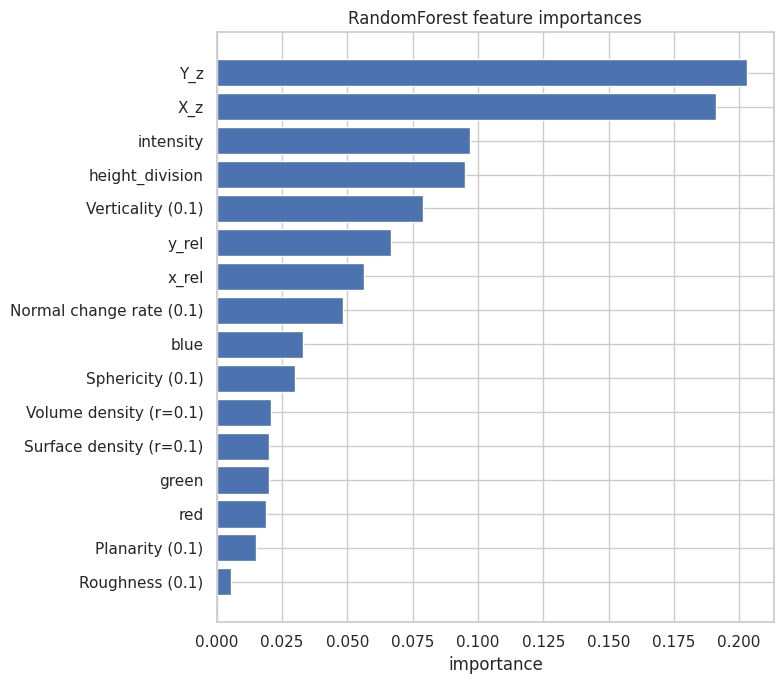

Rendering SHAP summary plot for Experiment A (may take time)...


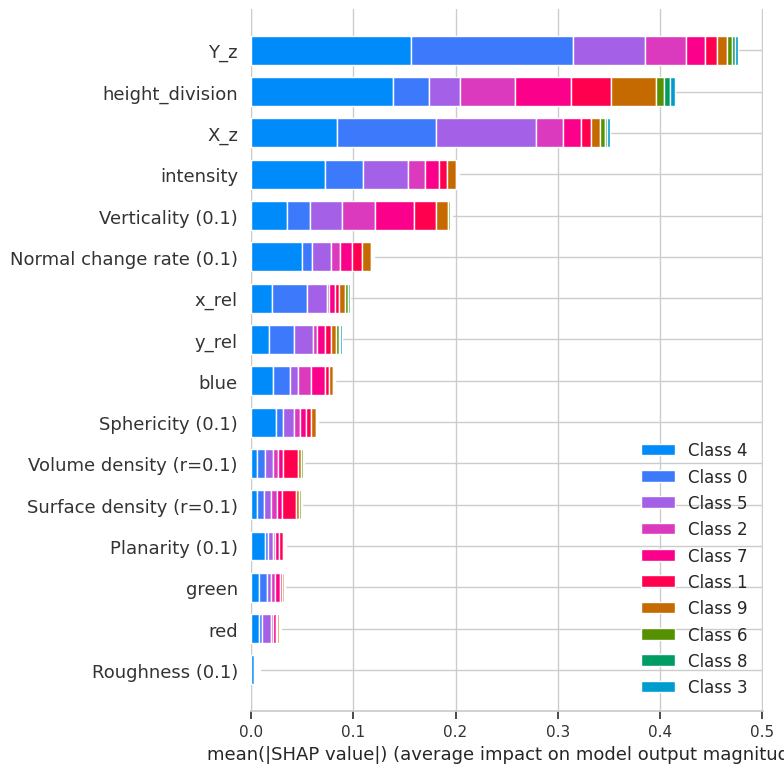


=== Experiment B: Spatial holdout (model_b) ===
Could not compute RF importances for model_b: name 'model_b' is not defined
SHAP not available or not computed for Experiment B


In [24]:
# Feature importance: RandomForest importances and SHAP summary (if available)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def show_rf_importances(model, features, topk=20):
    imp = model.feature_importances_
    df_imp = pd.DataFrame({'feature': features, 'importance': imp})
    df_imp = df_imp.sort_values('importance', ascending=False).reset_index(drop=True)
    display(df_imp.head(topk))
    plt.figure(figsize=(8, min(0.35*topk, 8)))
    plt.barh(df_imp['feature'].head(topk)[::-1], df_imp['importance'].head(topk)[::-1])
    plt.xlabel('importance')
    plt.title('RandomForest feature importances')
    plt.tight_layout()
    plt.show()

# Show for Experiment A
print('\n=== Experiment A: Random sampling (model_a) ===')
try:
    show_rf_importances(model_a, MODEL_FEATURES, topk=20)
except Exception as e:
    print('Could not compute RF importances for model_a:', e)

# SHAP for Experiment A (if available)
if 'shap' in globals() and shap is not None and 'explainer_a' in globals() and explainer_a is not None and 'shap_vals_a' in globals() and shap_vals_a is not None:
    try:
        X_test_s = scaler_a.transform(X_test)
        # determine subset length used to compute shap_vals_a
        if isinstance(shap_vals_a, list):
            nrows = shap_vals_a[0].shape[0]
        else:
            nrows = shap_vals_a.shape[0]
        subset = X_test_s[:nrows]
        print('Rendering SHAP summary plot for Experiment A (may take time)...')
        shap.summary_plot(shap_vals_a, subset, feature_names=MODEL_FEATURES)
    except Exception as e:
        print('SHAP plot failed for Experiment A:', e)
else:
    print('SHAP not available or not computed for Experiment A')

# Show for Experiment B
print('\n=== Experiment B: Spatial holdout (model_b) ===')
try:
    show_rf_importances(model_b, MODEL_FEATURES, topk=20)
except Exception as e:
    print('Could not compute RF importances for model_b:', e)

# SHAP for Experiment B
if 'shap' in globals() and shap is not None and 'explainer_b' in globals() and explainer_b is not None and 'shap_vals_b' in globals() and shap_vals_b is not None:
    try:
        X_test_b_s = scaler_b.transform(X_test_b)
        if isinstance(shap_vals_b, list):
            nrows = shap_vals_b[0].shape[0]
        else:
            nrows = shap_vals_b.shape[0]
        subset_b = X_test_b_s[:nrows]
        print('Rendering SHAP summary plot for Experiment B (may take time)...')
        shap.summary_plot(shap_vals_b, subset_b, feature_names=MODEL_FEATURES)
    except Exception as e:
        print('SHAP plot failed for Experiment B:', e)
else:
    print('SHAP not available or not computed for Experiment B')

In [25]:
model_a

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
y_pred

NameError: name 'y_pred' is not defined